# ScreenMind — Milestone 2: Data Acquisition & EDA
### BRFSS 2024 (`LLCP2024.XPT`)

**Goal:** Understand the BRFSS 2024 dataset before touching a model.

We'll work through:
1. Loading the raw XPT file
2. Selecting and understanding the relevant 2024 columns
3. Cleaning special survey codes (88=none, 77=don't know, 99=refused)
4. Analyzing distributions, missing values, and correlations
5. Visualizing relationships between lifestyle/wellbeing variables and mental health

**Before running:** Make sure `data/raw/LLCP2024.XPT` exists.

---
**Key differences vs 2023:**
- `SEX1` was renamed → `SEXVAR`
- `SLEPTIM1` (sleep hours) is **not** in the 2024 core module — moved to optional state modules
- `QLMENTL2` also absent in 2024
- New 2024 variables: `LSATISFY`, `EMTSUPRT`, `SDLONELY`, `SDHBILLS` (social determinants of health)
- `_MENT14D`: CDC pre-computed ≥14 bad mental health days classification target

## 1. Imports

In [37]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 5)

print('Imports OK')

Imports OK


## 2. Load the Raw Data

**Why XPT?** BRFSS uses SAS Transport Format — a binary format public health agencies have used for decades. pandas reads it with `pd.read_sas()`.

**Warning:** This file is ~1.5 GB. Loading takes 1–3 minutes.

In [38]:
RAW_DATA_PATH = '../data/raw/LLCP2024.XPT'

print('Loading BRFSS 2024 data (1–3 minutes)...')
df_raw = pd.read_sas(RAW_DATA_PATH, encoding='latin-1')
print(f'Loaded! Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]:,} columns')

Loading BRFSS 2024 data (1–3 minutes)...
Loaded! Shape: 457,670 rows × 301 columns


## 3. Quick Orientation

In [39]:
print(f'Rows:    {df_raw.shape[0]:,}')
print(f'Columns: {df_raw.shape[1]:,}')
print(f'Memory:  {df_raw.memory_usage(deep=True).sum() / 1e9:.2f} GB')
print(f'Dtypes:  {dict(df_raw.dtypes.value_counts())}')

Rows:    457,670
Columns: 301
Memory:  1.21 GB
Dtypes:  {dtype('float64'): np.int64(296), <StringDtype(storage='python', na_value=nan)>: np.int64(5)}


## 4. Select Relevant Columns

### Column guide — verified against 2024 codebook (`USCODE24_LLCP_082125.HTML`)

| Column | Description | Valid codes |
|--------|-------------|-------------|
| `MENTHLTH` | Days mental health not good (past 30) | 1–30; **88=none→0**, 77/99→NaN |
| `PHYSHLTH` | Days physical health not good (past 30) | 1–30; 88=none→0, 77/99→NaN |
| `POORHLTH` | Days poor health limited usual activities | 1–30; 88=none→0, 77/99→NaN |
| `GENHLTH` | Self-rated general health | 1=Excellent … 5=Poor; 7/9→NaN |
| `ADDEPEV3` | Ever told had depressive disorder | 1=Yes, 2=No; 7/9→NaN |
| `LSATISFY` | Life satisfaction | 1=Very satisfied … 4=Very dissatisfied; 7/9→NaN |
| `EMTSUPRT` | How often get needed emotional support | 1=Always … 5=Never; 7/9→NaN |
| `SDLONELY` | How often feel lonely | 1=Always … 5=Never; 7/9→NaN |
| `SDHBILLS` | Hard to pay bills in past 12 months | 1=Yes, 2=No; 7/9→NaN |
| `EXERANY2` | Any exercise in past 30 days | 1=Yes, 2=No; 7/9→NaN |
| `SMOKE100` | Smoked ≥100 cigarettes in lifetime | 1=Yes, 2=No; 7/9→NaN |
| `SEXVAR` | Sex of respondent (**was SEX1 in 2023**) | 1=Male, 2=Female |
| `EMPLOY1` | Employment status | 1–8 categories; 9→NaN |
| `INCOME3` | Annual household income | 1–11 categories; 77/99→NaN |
| `EDUCA` | Highest education level | 1–6 categories; 9→NaN |
| `_AGEG5YR` | Age in 5-year bands (CDC computed) | 1–13 valid; 14→NaN |
| `_BMI5CAT` | BMI category (CDC computed) | 1=Underweight … 4=Obese |
| `_MENT14D` | ≥14 bad mental health days (CDC computed) | 1=0 days, 2=1–13 days, 3=≥14 days; 9→NaN |

> **Why no sleep column?** `SLEPTIM1` moved to an optional state-added module in 2024 and is absent from `LLCP2024.XPT`. We use `SDLONELY`, `LSATISFY`, and `EMTSUPRT` as psychosocial proxies — these are well-validated predictors of mental health burden in the literature.

In [40]:
COLUMNS_OF_INTEREST = [
    # ── Targets ───────────────────────────────────────────────────
    'MENTHLTH',    # regression target: poor mental health days (0-30)
    '_MENT14D',    # CDC-computed classification target (≥14 days)
    # ── Physical health ───────────────────────────────────────────
    'PHYSHLTH',
    'POORHLTH',
    'GENHLTH',
    # ── Mental health history & psychosocial wellbeing ────────────
    'ADDEPEV3',    # depression diagnosis history
    'LSATISFY',    # life satisfaction (1=very satisfied … 4=very dissatisfied)
    'EMTSUPRT',    # emotional support availability (1=always … 5=never)
    'SDLONELY',    # loneliness frequency (1=always … 5=never)
    # ── Social determinants of health ─────────────────────────────
    'SDHBILLS',    # financial stress: hard to pay bills
    # ── Lifestyle behaviors ───────────────────────────────────────
    'EXERANY2',
    'SMOKE100',
    # ── Demographics ──────────────────────────────────────────────
    'SEXVAR',      # NOTE: was SEX1 in 2023 — renamed SEXVAR in 2024
    'EMPLOY1',
    'INCOME3',
    'EDUCA',
    # ── CDC-computed variables ────────────────────────────────────
    '_AGEG5YR',
    '_BMI5CAT',
]

available = [c for c in COLUMNS_OF_INTEREST if c in df_raw.columns]
missing   = [c for c in COLUMNS_OF_INTEREST if c not in df_raw.columns]

print(f'Found {len(available)}/{len(COLUMNS_OF_INTEREST)} columns')
if missing:
    print(f'Not found in this dataset: {missing}')

df = df_raw[available].copy()
print(f'\nWorking dataframe: {df.shape[0]:,} rows × {df.shape[1]} columns')

Found 18/18 columns

Working dataframe: 457,670 rows × 18 columns


## 5. Understanding BRFSS Special Codes

BRFSS is a telephone survey — not everyone answers every question. Non-answers are encoded as numbers, **not** left blank. If we don't clean these, the model trains on garbage.

| Code | Meaning | Action |
|------|---------|--------|
| `88` | None / zero days | → `0` (they said "none", not missing) |
| `77` or `7` | Don't know | → `NaN` |
| `99` or `9` | Refused | → `NaN` |

**Critical for `MENTHLTH`:** code `88` means zero bad days. If treated as the number 88, our target becomes wildly wrong (88 days out of 30 is impossible). This is the single most important cleaning step.

In [41]:
print('Raw MENTHLTH value counts (top 15):')
print(df['MENTHLTH'].value_counts().sort_index().head(15))
print()
print('Unique values (sorted):', sorted(df['MENTHLTH'].dropna().unique().astype(int)))

Raw MENTHLTH value counts (top 15):
MENTHLTH
1.0     15412
2.0     25180
3.0     15961
4.0      8381
5.0     21369
6.0      2374
7.0      8277
8.0      1873
9.0       332
10.0    16465
11.0      145
12.0     1334
13.0      187
14.0     2847
15.0    15317
Name: count, dtype: int64

Unique values (sorted): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(77), np.int64(88), np.int64(99)]


## 6. Clean Sentinel Codes

In [42]:
def clean_days_column(s: pd.Series) -> pd.Series:
    """For 1-30 day columns: 88→0 (none), 77/99→NaN."""
    s = s.replace(88, 0)
    s = s.replace([77, 99], np.nan)
    return s

def clean_binary(s: pd.Series) -> pd.Series:
    """1=Yes/2=No → 1=Yes/0=No; 7/9→NaN."""
    s = s.replace(2, 0)
    s = s.replace([7, 9], np.nan)
    return s

def clean_scale(s: pd.Series) -> pd.Series:
    """Likert-scale columns: invalidate 7/9."""
    return s.replace([7, 9], np.nan)

# Days columns (88=none, 77/99=invalid)
df['MENTHLTH'] = clean_days_column(df['MENTHLTH'])
df['PHYSHLTH']  = clean_days_column(df['PHYSHLTH'])
if 'POORHLTH' in df.columns:
    df['POORHLTH'] = clean_days_column(df['POORHLTH'])

# Ordinal health (1=excellent, 5=poor)
df['GENHLTH'] = clean_scale(df['GENHLTH'])

# Binary yes/no columns
for col in ['ADDEPEV3', 'EXERANY2', 'SMOKE100', 'SDHBILLS']:
    if col in df.columns:
        df[col] = clean_binary(df[col])

# SEXVAR: 1=Male, 2=Female → recode to 1=Male, 0=Female
if 'SEXVAR' in df.columns:
    df['SEXVAR'] = df['SEXVAR'].replace(2, 0)

# Likert scales (1=best … 4 or 5=worst)
for col in ['LSATISFY', 'EMTSUPRT', 'SDLONELY']:
    if col in df.columns:
        df[col] = clean_scale(df[col])

# Ordinal: employment, income, education
for col in ['EMPLOY1', 'INCOME3', 'EDUCA']:
    if col in df.columns:
        df[col] = df[col].replace([77, 99, 7, 9], np.nan)

# Age group: 1–13 valid; 14=don't know/refused
if '_AGEG5YR' in df.columns:
    df['_AGEG5YR'] = df['_AGEG5YR'].replace(14, np.nan)

# _MENT14D: 1=0 days, 2=1-13 days, 3=≥14 days; 9=missing
if '_MENT14D' in df.columns:
    df['_MENT14D'] = df['_MENT14D'].replace(9, np.nan)

print('Cleaning complete.')
print(f'MENTHLTH range: {df["MENTHLTH"].min():.0f}–{df["MENTHLTH"].max():.0f}')
print(f'MENTHLTH NaNs:  {df["MENTHLTH"].isna().sum():,}')

Cleaning complete.
MENTHLTH range: 0–30
MENTHLTH NaNs:  8,156


## 7. Missing Value Analysis

### Three types of missing data (MCAR / MAR / MNAR)

| Type | Meaning | BRFSS example |
|------|---------|---------------|
| **MCAR** | Completely random | Phone disconnected mid-survey |
| **MAR** | Depends on *other* observed variables | Older respondents skip income questions |
| **MNAR** | Depends on the *missing value itself* | Severely depressed people refuse to report mental health days |

**MNAR is dangerous:** if the sickest people systematically skip `MENTHLTH`, our model skews optimistic. We can't fix it, but we document it.

Missing (%) per column:
EMTSUPRT    56.16
SDHBILLS    55.98
LSATISFY    55.87
SDLONELY    55.83
INCOME3     44.55
POORHLTH    42.61
EMPLOY1     33.94
_BMI5CAT     9.40
SMOKE100     6.88
PHYSHLTH     2.42
_AGEG5YR     1.82
MENTHLTH     1.78
_MENT14D     1.78
ADDEPEV3     0.58
EDUCA        0.52
EXERANY2     0.29
GENHLTH      0.29
SEXVAR       0.00


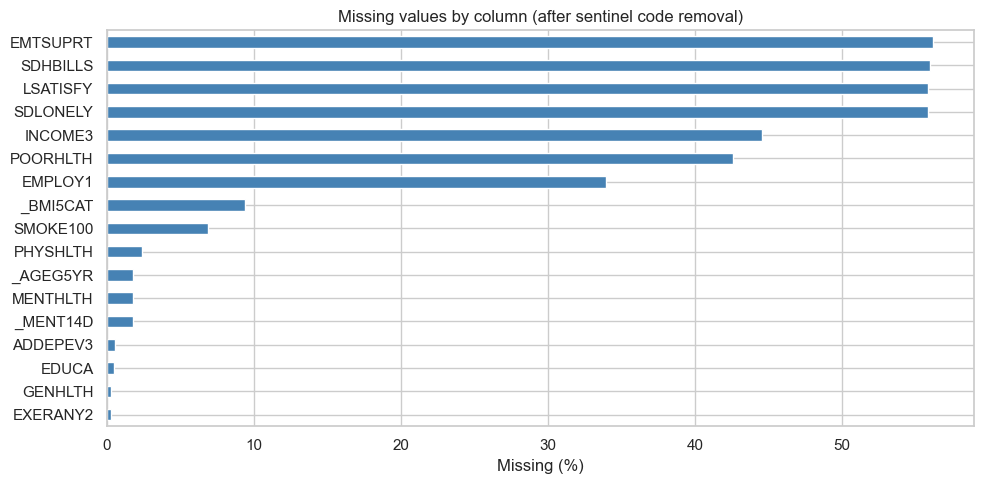

In [43]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
print('Missing (%) per column:')
print(missing_pct.to_string())

fig, ax = plt.subplots(figsize=(10, 5))
nonzero = missing_pct[missing_pct > 0].sort_values()
nonzero.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Missing (%)')
ax.set_title('Missing values by column (after sentinel code removal)')
plt.tight_layout()
plt.show()

## 8. Target Variable: MENTHLTH

In [44]:
target = df['MENTHLTH'].dropna()
print('=== MENTHLTH (poor mental health days, past 30) ===')
print(target.describe().round(2))
print(f'\nWith 0 bad days:      {(target == 0).mean()*100:.1f}%  ← zero-inflated!')
print(f'With >14 bad days:    {(target > 14).mean()*100:.1f}%  ← high-risk group')
print(f'With all 30 bad days: {(target == 30).mean()*100:.1f}%')

=== MENTHLTH (poor mental health days, past 30) ===
count    449514.00
mean          4.41
std           8.36
min           0.00
25%           0.00
50%           0.00
75%           5.00
max          30.00
Name: MENTHLTH, dtype: float64

With 0 bad days:      60.0%  ← zero-inflated!
With >14 bad days:    13.2%  ← high-risk group
With all 30 bad days: 6.1%


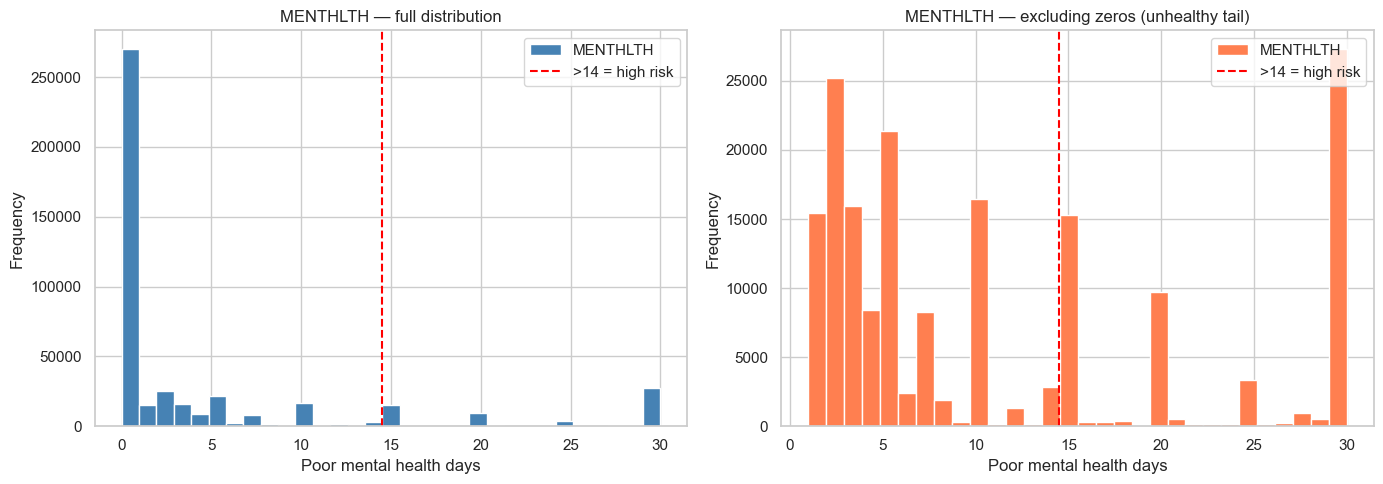

Zero-inflated distribution: modeling challenge addressed in Milestone 4 with loss weighting.


In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

target.plot(kind='hist', bins=31, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].axvline(14.5, color='red', linestyle='--', label='>14 = high risk')
axes[0].set_xlabel('Poor mental health days')
axes[0].set_title('MENTHLTH — full distribution')
axes[0].legend()

target[target > 0].plot(kind='hist', bins=30, ax=axes[1], color='coral', edgecolor='white')
axes[1].axvline(14.5, color='red', linestyle='--', label='>14 = high risk')
axes[1].set_xlabel('Poor mental health days')
axes[1].set_title('MENTHLTH — excluding zeros (unhealthy tail)')
axes[1].legend()

plt.tight_layout()
plt.show()
print('Zero-inflated distribution: modeling challenge addressed in Milestone 4 with loss weighting.')

## 9. Loneliness vs Mental Health (SDLONELY)

Scale: 1=Always lonely … 5=Never lonely. This is one of the strongest psychosocial predictors of mental health burden.

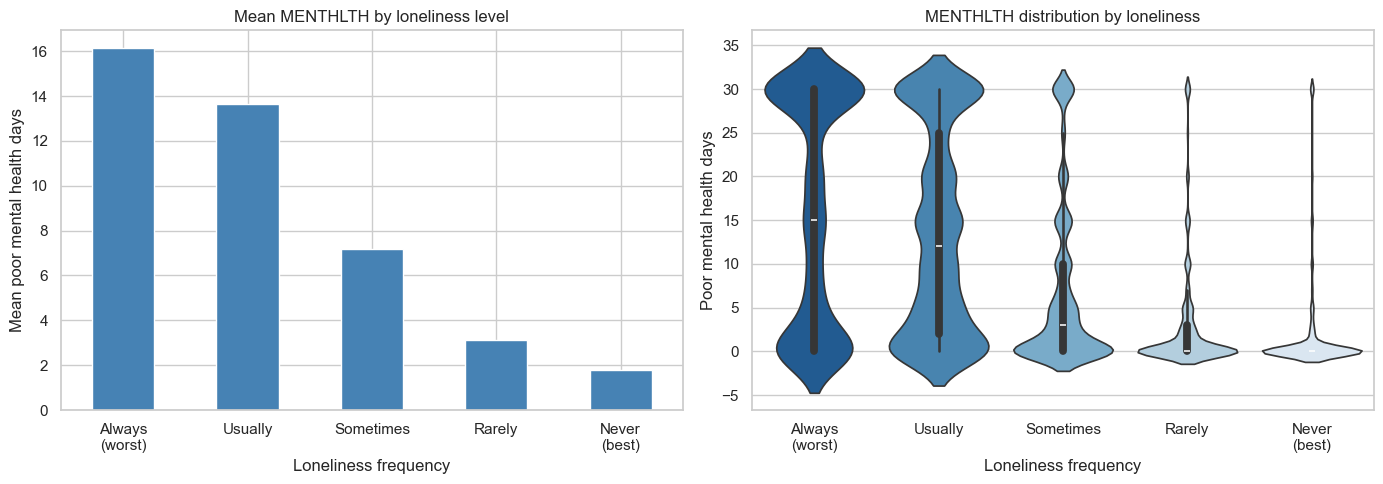

In [46]:
if 'SDLONELY' in df.columns:
    lone = df[['SDLONELY', 'MENTHLTH']].dropna()
    labels = {1: 'Always\n(worst)', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never\n(best)'}

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    means = lone.groupby('SDLONELY')['MENTHLTH'].mean()
    means.index = [labels[i] for i in means.index]
    means.plot(kind='bar', ax=axes[0], color='steelblue', rot=0)
    axes[0].set_xlabel('Loneliness frequency')
    axes[0].set_ylabel('Mean poor mental health days')
    axes[0].set_title('Mean MENTHLTH by loneliness level')

    lone['label'] = lone['SDLONELY'].map(labels)
    order = [labels[i] for i in sorted(labels)]
    sns.violinplot(data=lone, x='label', y='MENTHLTH', order=order,
                ax=axes[1], palette='Blues_r')
    axes[1].set_xlabel('Loneliness frequency')
    axes[1].set_ylabel('Poor mental health days')
    axes[1].set_title('MENTHLTH distribution by loneliness')

    plt.tight_layout()
    plt.show()

## 10. Life Satisfaction (LSATISFY) and Emotional Support (EMTSUPRT)

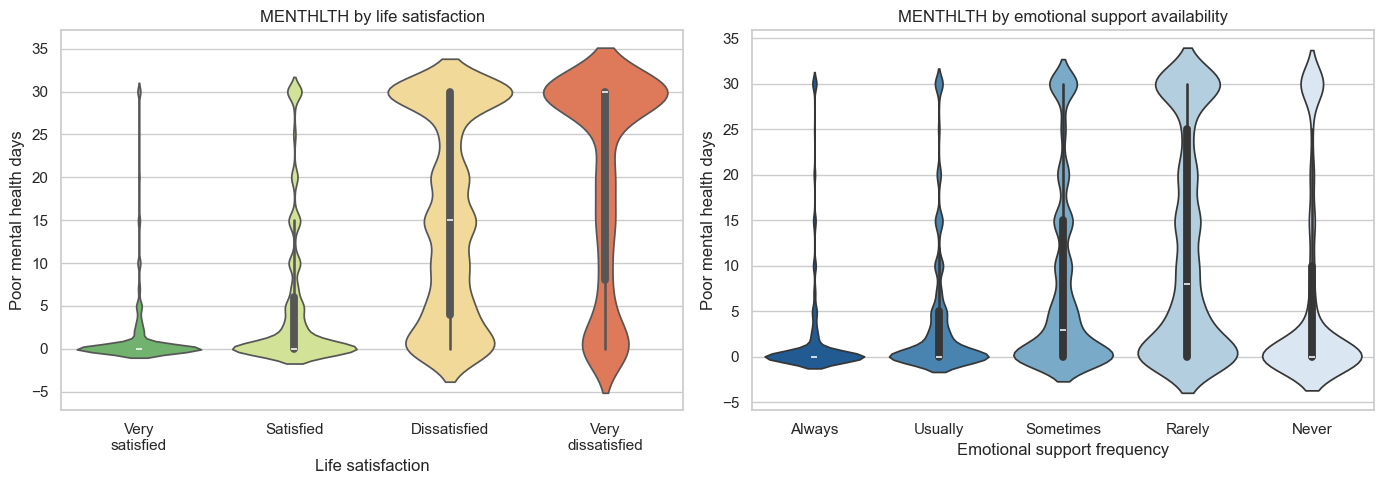

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Life satisfaction
if 'LSATISFY' in df.columns:
    sat = df[['LSATISFY', 'MENTHLTH']].dropna()
    sat_labels = {1: 'Very\nsatisfied', 2: 'Satisfied', 3: 'Dissatisfied', 4: 'Very\ndissatisfied'}
    sat['label'] = sat['LSATISFY'].map(sat_labels)
    order = [sat_labels[i] for i in sorted(sat_labels)]
    sns.violinplot(data=sat, x='label', y='MENTHLTH', order=order,
                ax=axes[0], palette='RdYlGn_r')
    axes[0].set_xlabel('Life satisfaction')
    axes[0].set_ylabel('Poor mental health days')
    axes[0].set_title('MENTHLTH by life satisfaction')

# Emotional support
if 'EMTSUPRT' in df.columns:
    emt = df[['EMTSUPRT', 'MENTHLTH']].dropna()
    emt_labels = {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}
    emt['label'] = emt['EMTSUPRT'].map(emt_labels)
    order = [emt_labels[i] for i in sorted(emt_labels)]
    sns.violinplot(data=emt, x='label', y='MENTHLTH', order=order,
                ax=axes[1], palette='Blues_r')
    axes[1].set_xlabel('Emotional support frequency')
    axes[1].set_ylabel('Poor mental health days')
    axes[1].set_title('MENTHLTH by emotional support availability')

plt.tight_layout()
plt.show()

## 11. Depression History, Physical Health, and Financial Stress

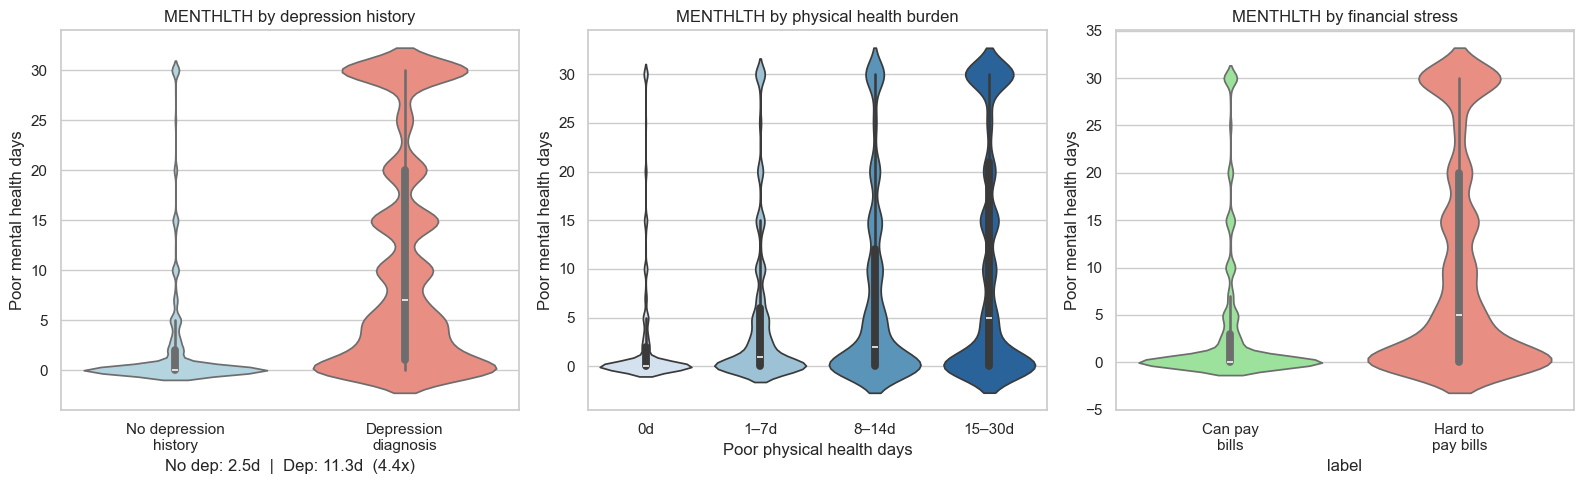

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Depression history
if 'ADDEPEV3' in df.columns:
    dep = df[['ADDEPEV3', 'MENTHLTH']].dropna()
    dep['label'] = dep['ADDEPEV3'].map({0: 'No depression\nhistory', 1: 'Depression\ndiagnosis'})
    sns.violinplot(data=dep, x='label', y='MENTHLTH', palette=['lightblue', 'salmon'],
                ax=axes[0])
    axes[0].set_ylabel('Poor mental health days')
    axes[0].set_title('MENTHLTH by depression history')
    no_dep  = dep[dep['ADDEPEV3'] == 0]['MENTHLTH'].mean()
    has_dep = dep[dep['ADDEPEV3'] == 1]['MENTHLTH'].mean()
    axes[0].set_xlabel(f'No dep: {no_dep:.1f}d  |  Dep: {has_dep:.1f}d  ({has_dep/no_dep:.1f}x)')

# Physical health (binned)
phys = df[['PHYSHLTH', 'MENTHLTH']].dropna()
phys['bin'] = pd.cut(phys['PHYSHLTH'], bins=[-1,0,7,14,30],
                      labels=['0d','1–7d','8–14d','15–30d'])
sns.violinplot(data=phys, x='bin', y='MENTHLTH', palette='Blues',
            ax=axes[1])
axes[1].set_xlabel('Poor physical health days')
axes[1].set_ylabel('Poor mental health days')
axes[1].set_title('MENTHLTH by physical health burden')

# Financial stress
if 'SDHBILLS' in df.columns:
    bills = df[['SDHBILLS', 'MENTHLTH']].dropna()
    bills['label'] = bills['SDHBILLS'].map({0: 'Can pay\nbills', 1: 'Hard to\npay bills'})
    sns.violinplot(data=bills, x='label', y='MENTHLTH', palette=['lightgreen', 'salmon'],
                ax=axes[2])
    axes[2].set_ylabel('Poor mental health days')
    axes[2].set_title('MENTHLTH by financial stress')

plt.tight_layout()
plt.show()

## 12. Exercise and Smoking

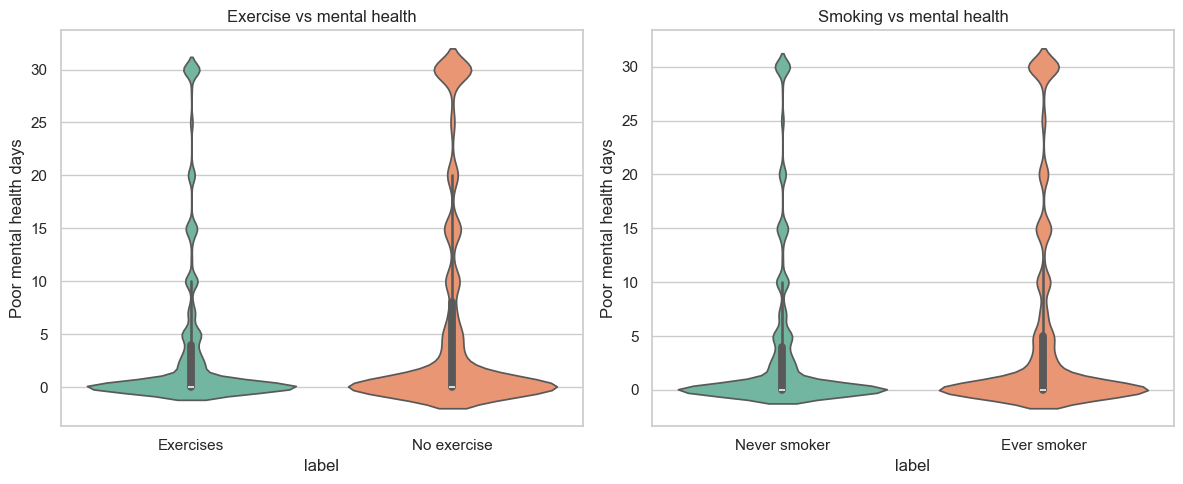

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col, label_map, title in [
    (axes[0], 'EXERANY2', {0: 'No exercise', 1: 'Exercises'},    'Exercise vs mental health'),
    (axes[1], 'SMOKE100', {0: 'Never smoker', 1: 'Ever smoker'}, 'Smoking vs mental health'),
]:
    if col not in df.columns:
        continue
    d = df[[col, 'MENTHLTH']].dropna()
    d['label'] = d[col].map(label_map)
    sns.violinplot(data=d, x='label', y='MENTHLTH', palette='Set2',
                ax=ax)
    ax.set_ylabel('Poor mental health days')
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 13. Correlation Heatmap

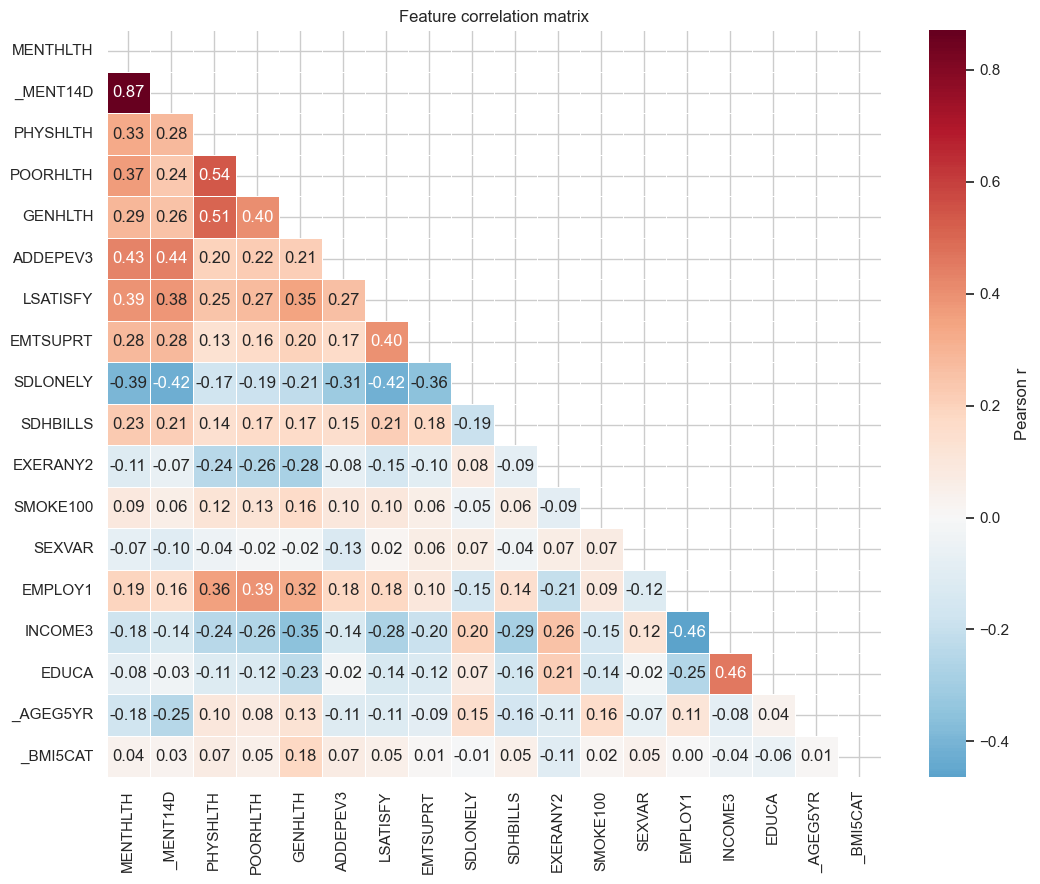


Correlation with MENTHLTH (sorted by absolute value):
_MENT14D    0.870
ADDEPEV3    0.429
SDLONELY   -0.391
LSATISFY    0.390
POORHLTH    0.369
PHYSHLTH    0.333
GENHLTH     0.290
EMTSUPRT    0.278
SDHBILLS    0.227
EMPLOY1     0.194
INCOME3    -0.180
_AGEG5YR   -0.176
EXERANY2   -0.110
SMOKE100    0.092
EDUCA      -0.078
SEXVAR     -0.073
_BMI5CAT    0.041
Name: MENTHLTH, dtype: float64


In [50]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Pearson r'})
ax.set_title('Feature correlation matrix')
plt.tight_layout()
plt.show()

if 'MENTHLTH' in corr:
    print('\nCorrelation with MENTHLTH (sorted by absolute value):')
    print(corr['MENTHLTH'].drop('MENTHLTH').sort_values(key=abs, ascending=False).round(3))

## 14. Define Classification Target

In [51]:
HIGH_RISK_THRESHOLD = 14  # days/month — standard public health cutoff

df['high_risk'] = np.where(
    df['MENTHLTH'].isna(), np.nan,
    (df['MENTHLTH'] > HIGH_RISK_THRESHOLD).astype(float)
)

n_high  = df['high_risk'].sum()
n_total = df['high_risk'].notna().sum()
print(f'High risk (>14 days):  {n_high:,.0f} / {n_total:,} = {n_high/n_total*100:.1f}%')
print(f'Low risk  (≤14 days):  {n_total-n_high:,.0f} / {n_total:,} = {(1-n_high/n_total)*100:.1f}%')
print()
print('CLASS IMBALANCE: naive "always predict low risk" = ~85% accuracy but clinically useless.')
print('Milestone 4 addresses this with loss weighting.')

High risk (>14 days):  59,468 / 449,514 = 13.2%
Low risk  (≤14 days):  390,046 / 449,514 = 86.8%

CLASS IMBALANCE: naive "always predict low risk" = ~85% accuracy but clinically useless.
Milestone 4 addresses this with loss weighting.


## 15. EDA Summary

In [52]:
print('=' * 60)
print('EDA SUMMARY — BRFSS 2024')
print('=' * 60)
print(f'Dataset: {df.shape[0]:,} respondents, {df.shape[1]} features selected')
print()
print('TARGET (MENTHLTH):')
print(f'  Mean: {df["MENTHLTH"].mean():.1f} days  |  Median: {df["MENTHLTH"].median():.0f} days')
print(f'  Zero-inflated: {(df["MENTHLTH"]==0).mean()*100:.0f}% report 0 bad days')
print(f'  High risk (>14 days): ~{df["high_risk"].mean()*100:.0f}%')
print()
print('KEY FINDINGS:')
print('  1. Depression history    — strongest single predictor')
print('  2. Loneliness            — strongly graded across all levels')
print('  3. Life dissatisfaction  — large gradient from satisfied to dissatisfied')
print('  4. Physical health       — strong positive correlation with mental burden')
print('  5. Financial stress      — hard-to-pay-bills group has markedly higher burden')
print('  6. Emotional support     — protective: "never get support" has much higher burden')
print('  7. Exercise / smoking    — secondary but consistent effects')
print()
print('2024-SPECIFIC NOTES:')
print('  - SLEPTIM1 (sleep hours) not in 2024 core module')
print('  - SEX1 renamed to SEXVAR')
print('  - New: SDLONELY, LSATISFY, EMTSUPRT, SDHBILLS (social determinants module)')
print()
print('DATA QUALITY:')
print('  - Potential MNAR: severely depressed respondents may underreport')
print('  - Class imbalance must be addressed in training')
print()
print('NEXT: Milestone 3 — feature engineering, preprocessing, train/val/test split')

EDA SUMMARY — BRFSS 2024
Dataset: 457,670 respondents, 19 features selected

TARGET (MENTHLTH):
  Mean: 4.4 days  |  Median: 0 days
  Zero-inflated: 59% report 0 bad days
  High risk (>14 days): ~13%

KEY FINDINGS:
  1. Depression history    — strongest single predictor
  2. Loneliness            — strongly graded across all levels
  3. Life dissatisfaction  — large gradient from satisfied to dissatisfied
  4. Physical health       — strong positive correlation with mental burden
  5. Financial stress      — hard-to-pay-bills group has markedly higher burden
  6. Emotional support     — protective: "never get support" has much higher burden
  7. Exercise / smoking    — secondary but consistent effects

2024-SPECIFIC NOTES:
  - SLEPTIM1 (sleep hours) not in 2024 core module
  - SEX1 renamed to SEXVAR
  - New: SDLONELY, LSATISFY, EMTSUPRT, SDHBILLS (social determinants module)

DATA QUALITY:
  - Potential MNAR: severely depressed respondents may underreport
  - Class imbalance must be ad

In [53]:
print('=' * 60)
print('EDA SUMMARY — BRFSS 2023')
print('=' * 60)
print(f'Dataset: {df.shape[0]:,} respondents, {df.shape[1]} features selected')
print()
print('TARGET (MENTHLTH):')
print(f'  Mean: {df["MENTHLTH"].mean():.1f} days | Median: {df["MENTHLTH"].median():.0f} days')
print(f'  Highly zero-inflated: {(df["MENTHLTH"] == 0).mean()*100:.0f}% report 0 bad days')
print(f'  High risk (>14 days): ~{df["high_risk"].mean()*100:.0f}% of respondents')
print()
print('KEY FINDINGS:')
print('  1. Sleep: U-shaped — both <6h and >9h associated with worse mental health')
print('  2. Depression history: strongest single predictor')
print('  3. Physical health: strong positive correlation with mental health')
print('  4. Exercise: exercisers report fewer bad mental health days')
print('  5. Smoking: associated with worse outcomes')
print()
print('DATA QUALITY NOTES:')
print('  - Possible MNAR: severely depressed people may underreport')
print('  - Survey bias: telephone survey over-represents certain demographics')
print('  - Class imbalance must be addressed before training')
print()
print('NEXT: Milestone 3 — feature engineering, preprocessing, train/val/test split')

EDA SUMMARY — BRFSS 2023
Dataset: 457,670 respondents, 19 features selected

TARGET (MENTHLTH):
  Mean: 4.4 days | Median: 0 days
  Highly zero-inflated: 59% report 0 bad days
  High risk (>14 days): ~13% of respondents

KEY FINDINGS:
  1. Sleep: U-shaped — both <6h and >9h associated with worse mental health
  2. Depression history: strongest single predictor
  3. Physical health: strong positive correlation with mental health
  4. Exercise: exercisers report fewer bad mental health days
  5. Smoking: associated with worse outcomes

DATA QUALITY NOTES:
  - Possible MNAR: severely depressed people may underreport
  - Survey bias: telephone survey over-represents certain demographics
  - Class imbalance must be addressed before training

NEXT: Milestone 3 — feature engineering, preprocessing, train/val/test split
